In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# Check if GPU is available and set device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available -> use CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths for datasets
# evaluation_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/evaluation_dataset.csv'
# initial_labeling_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/initial_labeling_dataset.csv'
# semi_supervised_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/semi_supervised_dataset.csv'
evaluation_dataset_path = './evaluation_dataset.csv'
initial_labeling_dataset_path = './initial_labeling_dataset.csv'
semi_supervised_dataset_path = './semi_supervised_dataset.csv'

# Load datasets
df_evaluation_subjective = pd.read_csv(evaluation_dataset_path)
df_initial_labeling_subjective = pd.read_csv(initial_labeling_dataset_path)
df_semi_supervised_subjective = pd.read_csv(semi_supervised_dataset_path)

In [ ]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, dataloader, optimizer):
    """Train the model on training data."""
    model.train()  # Set model to training mode
    total_train_loss = 0

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Training"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(**inputs)  # Forward pass
        loss = outputs[0]  # Get loss
        total_train_loss += loss.item()  # Accumulate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Compute average loss
    avg_train_loss = total_train_loss / len(dataloader)
    print(f"Average training loss: {avg_train_loss}")

def evaluate_model(model, dataloader):
    """Evaluate the model's performance on a dataset."""
    model.eval()  # Set model to evaluation mode
    total_eval_accuracy = 0
    all_preds = []
    all_labels = []

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():  # Disable gradient calculation
            outputs = model(**inputs)

        logits = outputs[1]
        preds = torch.argmax(logits, dim=1).flatten()  # Get predictions

        # Accumulate predictions and labels
        all_preds.extend(preds.tolist())
        all_labels.extend(inputs['labels'].flatten().tolist())

        # Calculate accuracy
        total_eval_accuracy += torch.sum(preds == inputs['labels'].flatten()).item()

    # Compute average accuracy
    avg_accuracy = total_eval_accuracy / len(dataloader.dataset)
    print(f"Accuracy: {avg_accuracy}")

    # Generate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
    print("\nClassification Report:")
    print(report)
    return cm, report

def prepare_dataloader(df, tokenizer, batch_size=32, max_length=256):
    """Creates a DataLoader for model training or evaluation."""
    # Fill missing text entries
    df['post_comment_processed'].fillna("", inplace=True)

    # Map sentiment labels to integers
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = df['sentiment'].map(sentiment_mapping).values
    labels = torch.tensor(labels).long()

    # Tokenize text
    encoding = tokenizer(df['post_comment_processed'].tolist(),
                         add_special_tokens=True,
                         max_length=max_length,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return dataloader

def generate_pseudo_labels(model, data_loader, tokenizer, device, confidence_threshold=0.9):
    """Generates pseudo-labels for unlabeled data using the model."""
    model.eval()  # Set model to evaluation mode
    pseudo_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(data_loader, desc="Pseudo-labeling"):
            # Move batch to device
            input_ids, attention_mask = batch[:2]
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

            # Model prediction
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, preds = torch.max(probs, dim=1)

            # Select high-confidence predictions
            high_confidence_indices = max_probs > confidence_threshold
            high_confidence_texts = tokenizer.batch_decode(input_ids[high_confidence_indices], skip_special_tokens=True)
            high_confidence_labels = preds[high_confidence_indices].tolist()

            pseudo_labels.extend(zip(high_confidence_texts, high_confidence_labels))

    # Create DataFrame for pseudo-labeled data
    df_pseudo_labels = pd.DataFrame(pseudo_labels, columns=['post_comment_processed', 'sentiment'])
    df_pseudo_labels['sentiment'] = df_pseudo_labels['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

    return df_pseudo_labels

def update_semi_supervised_dataset(original_df, pseudo_labeled_df):
    """Updates the dataset by removing pseudo-labeled examples."""
    return original_df[~original_df['post_comment_processed'].isin(pseudo_labeled_df['post_comment_processed'])]


In [ ]:
# Initialize Electra model and tokenizer for sequence classification
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
electra_model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator',
                                                          num_labels=3, # Three sentiment classes: negative, neutral, positive
                                                          output_attentions=False,
                                                          output_hidden_states=False).to(device)

# Set up the optimizer with recommended settings
optimizer = AdamW(electra_model.parameters(), lr=5e-5, eps=1e-8)
epochs = 4  # Define the total number of training epochs

# Split initial labeling data for training and validation
df_train_initial, df_validation_initial = train_test_split(df_initial_labeling_subjective, test_size=0.2, random_state=42)

# Prepare dataloaders for initial training, validation, and evaluation
train_dataloader = prepare_dataloader(df_train_initial, electra_tokenizer, batch_size=16, max_length=128)
validation_dataloader = prepare_dataloader(df_validation_initial, electra_tokenizer, batch_size=16, max_length=128)
evaluation_dataloader = prepare_dataloader(df_evaluation_subjective, electra_tokenizer, batch_size=16, max_length=128)

# Initialize dataset for semi-supervised learning iterations
df_semi_supervised_current = df_semi_supervised_subjective.copy()

# Define dynamic threshold for pseudo-label generation
threshold = 0.95  # Initial threshold for pseudo-labeling
threshold_updates = {10: 0.9, 20: 0.85}  # Update thresholds based on iteration

# Semi-supervised learning loop
ssl_iterations = 22  # Set the total number of iterations for semi-supervised learning
for iteration in range(ssl_iterations):
    print(f"Iteration {iteration + 1}/{ssl_iterations}")

    # Adjust the threshold dynamically per iteration
    if iteration in threshold_updates:
        threshold = threshold_updates[iteration]

    # Prepare DataLoader for semi-supervised learning with the current dataset
    semi_supervised_data_loader = prepare_dataloader(df_semi_supervised_current, electra_tokenizer, batch_size=16, max_length=128)

    # Generate pseudo-labels and combine with the initial training data
    if iteration > 0:
        df_pseudo_labels = generate_pseudo_labels(electra_model, semi_supervised_data_loader, electra_tokenizer, device, threshold)
        combined_df = pd.concat([df_train_initial, df_pseudo_labels])  # Combine for retraining
        train_dataloader = prepare_dataloader(combined_df, electra_tokenizer, batch_size=16, max_length=128)

    # Recalculate the total steps for the learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train and evaluate the model with the updated dataloader
    train_model(electra_model, train_dataloader, optimizer)
    evaluate_model(electra_model, validation_dataloader)

    # Update the dataset for the next iteration
    if iteration > 0:
        df_semi_supervised_current = update_semi_supervised_dataset(df_semi_supervised_current, df_pseudo_labels)

    # Print the remaining number of unlabeled datasets
    print(f"Remaining unlabeled data after iteration {iteration + 1}: {len(df_semi_supervised_current)}")

print("Semi-Supervised Learning completed.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 1/22


Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.8617074790401994


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.6705607476635514

Classification Report:
              precision    recall  f1-score   support

    Negative     0.3944    0.1296    0.1951       216
     Neutral     0.6447    0.7481    0.6926       131
    Positive     0.7077    0.8802    0.7846       509

    accuracy                         0.6706       856
   macro avg     0.5823    0.5860    0.5574       856
weighted avg     0.6190    0.6706    0.6218       856

Remaining unlabeled data after iteration 1: 9978
Iteration 2/22


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.6333583321805313


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7978971962616822

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6567    0.7083    0.6815       216
     Neutral     0.7778    0.8015    0.7895       131
    Positive     0.8709    0.8350    0.8526       509

    accuracy                         0.7979       856
   macro avg     0.7684    0.7816    0.7745       856
weighted avg     0.8026    0.7979    0.7997       856

Remaining unlabeled data after iteration 2: 9978
Iteration 3/22


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.470314142302932


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7757009345794392

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6980    0.4815    0.5699       216
     Neutral     0.8571    0.6870    0.7627       131
    Positive     0.7807    0.9234    0.8461       509

    accuracy                         0.7757       856
   macro avg     0.7786    0.6973    0.7262       856
weighted avg     0.7715    0.7757    0.7636       856

Remaining unlabeled data after iteration 3: 9978
Iteration 4/22


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/415 [00:00<?, ?it/s]

Average training loss: 0.2162198847092419


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8212616822429907

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7353    0.6944    0.7143       216
     Neutral     0.8627    0.6718    0.7554       131
    Positive     0.8455    0.9136    0.8782       509

    accuracy                         0.8213       856
   macro avg     0.8145    0.7599    0.7826       856
weighted avg     0.8203    0.8213    0.8180       856

Remaining unlabeled data after iteration 4: 7063
Iteration 5/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/442 [00:00<?, ?it/s]

Training:   0%|          | 0/353 [00:00<?, ?it/s]

Average training loss: 0.21457279767450632


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8072429906542056

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6971    0.6713    0.6840       216
     Neutral     0.8763    0.6489    0.7456       131
    Positive     0.8367    0.9057    0.8698       509

    accuracy                         0.8072       856
   macro avg     0.8034    0.7419    0.7665       856
weighted avg     0.8075    0.8072    0.8039       856

Remaining unlabeled data after iteration 5: 5320
Iteration 6/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/333 [00:00<?, ?it/s]

Training:   0%|          | 0/322 [00:00<?, ?it/s]

Average training loss: 0.17641977211518317


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8037383177570093

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7847    0.5231    0.6278       216
     Neutral     0.8333    0.7634    0.7968       131
    Positive     0.8024    0.9332    0.8629       509

    accuracy                         0.8037       856
   macro avg     0.8068    0.7399    0.7625       856
weighted avg     0.8027    0.8037    0.7934       856

Remaining unlabeled data after iteration 6: 4119
Iteration 7/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/258 [00:00<?, ?it/s]

Training:   0%|          | 0/359 [00:00<?, ?it/s]

Average training loss: 0.2003493176352928


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8200934579439252

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8049    0.6111    0.6947       216
     Neutral     0.8031    0.7786    0.7907       131
    Positive     0.8283    0.9194    0.8715       509

    accuracy                         0.8201       856
   macro avg     0.8121    0.7697    0.7856       856
weighted avg     0.8186    0.8201    0.8145       856

Remaining unlabeled data after iteration 7: 2471
Iteration 8/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/155 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Average training loss: 0.13033205236777337


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8212616822429907

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7582    0.6389    0.6935       216
     Neutral     0.8264    0.7634    0.7937       131
    Positive     0.8409    0.9136    0.8757       509

    accuracy                         0.8213       856
   macro avg     0.8085    0.7719    0.7876       856
weighted avg     0.8178    0.8213    0.8172       856

Remaining unlabeled data after iteration 8: 2155
Iteration 9/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/135 [00:00<?, ?it/s]

Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average training loss: 0.11979510776296207


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8095794392523364

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7771    0.5648    0.6542       216
     Neutral     0.8462    0.7557    0.7984       131
    Positive     0.8110    0.9273    0.8653       509

    accuracy                         0.8096       856
   macro avg     0.8114    0.7493    0.7726       856
weighted avg     0.8078    0.8096    0.8018       856

Remaining unlabeled data after iteration 9: 1696
Iteration 10/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/106 [00:00<?, ?it/s]

Training:   0%|          | 0/280 [00:00<?, ?it/s]

Average training loss: 0.12686660365766977


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8072429906542056

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7436    0.6713    0.7056       216
     Neutral     0.8462    0.6718    0.7489       131
    Positive     0.8223    0.8998    0.8593       509

    accuracy                         0.8072       856
   macro avg     0.8040    0.7476    0.7713       856
weighted avg     0.8061    0.8072    0.8036       856

Remaining unlabeled data after iteration 10: 1366
Iteration 11/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/86 [00:00<?, ?it/s]

Training:   0%|          | 0/278 [00:00<?, ?it/s]

Average training loss: 0.11117860157270547


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8095794392523364

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7009    0.6944    0.6977       216
     Neutral     0.8725    0.6794    0.7639       131
    Positive     0.8407    0.8919    0.8656       509

    accuracy                         0.8096       856
   macro avg     0.8047    0.7553    0.7757       856
weighted avg     0.8103    0.8096    0.8077       856

Remaining unlabeled data after iteration 11: 1078
Iteration 12/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/68 [00:00<?, ?it/s]

Training:   0%|          | 0/264 [00:00<?, ?it/s]

Average training loss: 0.06797687712330089


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7908878504672897

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6349    0.7407    0.6838       216
     Neutral     0.8317    0.6412    0.7241       131
    Positive     0.8608    0.8507    0.8557       509

    accuracy                         0.7909       856
   macro avg     0.7758    0.7442    0.7545       856
weighted avg     0.7994    0.7909    0.7922       856

Remaining unlabeled data after iteration 12: 1018
Iteration 13/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/64 [00:00<?, ?it/s]

Training:   0%|          | 0/269 [00:00<?, ?it/s]

Average training loss: 0.08335227125365854


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.802570093457944

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7348    0.6157    0.6700       216
     Neutral     0.8273    0.6947    0.7552       131
    Positive     0.8195    0.9096    0.8622       509

    accuracy                         0.8026       856
   macro avg     0.7938    0.7400    0.7625       856
weighted avg     0.7993    0.8026    0.7973       856

Remaining unlabeled data after iteration 13: 880
Iteration 14/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/55 [00:00<?, ?it/s]

Training:   0%|          | 0/264 [00:00<?, ?it/s]

Average training loss: 0.0589447176612201


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8154205607476636

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7064    0.7130    0.7097       216
     Neutral     0.8333    0.7252    0.7755       131
    Positive     0.8569    0.8821    0.8693       509

    accuracy                         0.8154       856
   macro avg     0.7989    0.7734    0.7848       856
weighted avg     0.8153    0.8154    0.8147       856

Remaining unlabeled data after iteration 14: 842
Iteration 15/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/53 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.04532157681517643


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8235981308411215

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7450    0.6898    0.7163       216
     Neutral     0.8167    0.7481    0.7809       131
    Positive     0.8545    0.8998    0.8766       509

    accuracy                         0.8236       856
   macro avg     0.8054    0.7792    0.7913       856
weighted avg     0.8211    0.8236    0.8215       856

Remaining unlabeled data after iteration 15: 825
Iteration 16/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/52 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.03512861419685128


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8119158878504673

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7500    0.6806    0.7136       216
     Neutral     0.7951    0.7405    0.7668       131
    Positive     0.8383    0.8861    0.8615       509

    accuracy                         0.8119       856
   macro avg     0.7945    0.7690    0.7806       856
weighted avg     0.8094    0.8119    0.8097       856

Remaining unlabeled data after iteration 16: 804
Iteration 17/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/51 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.04845027497858022


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8119158878504673

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7214    0.6713    0.6954       216
     Neutral     0.8378    0.7099    0.7686       131
    Positive     0.8401    0.8978    0.8680       509

    accuracy                         0.8119       856
   macro avg     0.7998    0.7597    0.7773       856
weighted avg     0.8098    0.8119    0.8092       856

Remaining unlabeled data after iteration 17: 792
Iteration 18/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Average training loss: 0.04094583190731413


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8154205607476636

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7374    0.6759    0.7053       216
     Neutral     0.8455    0.7099    0.7718       131
    Positive     0.8376    0.9018    0.8685       509

    accuracy                         0.8154       856
   macro avg     0.8068    0.7625    0.7819       856
weighted avg     0.8135    0.8154    0.8125       856

Remaining unlabeled data after iteration 18: 790
Iteration 19/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Average training loss: 0.030910473984296482


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7897196261682243

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7410    0.5694    0.6440       216
     Neutral     0.8384    0.6336    0.7217       131
    Positive     0.7953    0.9234    0.8545       509

    accuracy                         0.7897       856
   macro avg     0.7915    0.7088    0.7401       856
weighted avg     0.7882    0.7897    0.7811       856

Remaining unlabeled data after iteration 19: 786
Iteration 20/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Average training loss: 0.02633990304107344


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8119158878504673

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6916    0.7269    0.7088       216
     Neutral     0.8136    0.7328    0.7711       131
    Positive     0.8650    0.8684    0.8667       509

    accuracy                         0.8119       856
   macro avg     0.7901    0.7760    0.7822       856
weighted avg     0.8134    0.8119    0.8122       856

Remaining unlabeled data after iteration 20: 782
Iteration 21/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/49 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.024967770060872262


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7978971962616822

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6890    0.6667    0.6776       216
     Neutral     0.8426    0.6947    0.7615       131
    Positive     0.8312    0.8802    0.8550       509

    accuracy                         0.7979       856
   macro avg     0.7876    0.7472    0.7647       856
weighted avg     0.7970    0.7979    0.7959       856

Remaining unlabeled data after iteration 21: 776
Iteration 22/22


<ipython-input-4-a472b76308e1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/49 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.030504706775049854


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8002336448598131

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7094    0.6667    0.6874       216
     Neutral     0.8400    0.6412    0.7273       131
    Positive     0.8264    0.8978    0.8606       509

    accuracy                         0.8002       856
   macro avg     0.7919    0.7352    0.7584       856
weighted avg     0.7989    0.8002    0.7965       856

Remaining unlabeled data after iteration 22: 776
Semi-Supervised Learning completed.



Final Evaluation on Test Set:


Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Accuracy: 0.8017676767676768

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7026    0.6528    0.6768       409
     Neutral     0.8333    0.6890    0.7543       254
    Positive     0.8330    0.8990    0.8648       921

    accuracy                         0.8018      1584
   macro avg     0.7897    0.7469    0.7653      1584
weighted avg     0.7994    0.8018    0.7985      1584



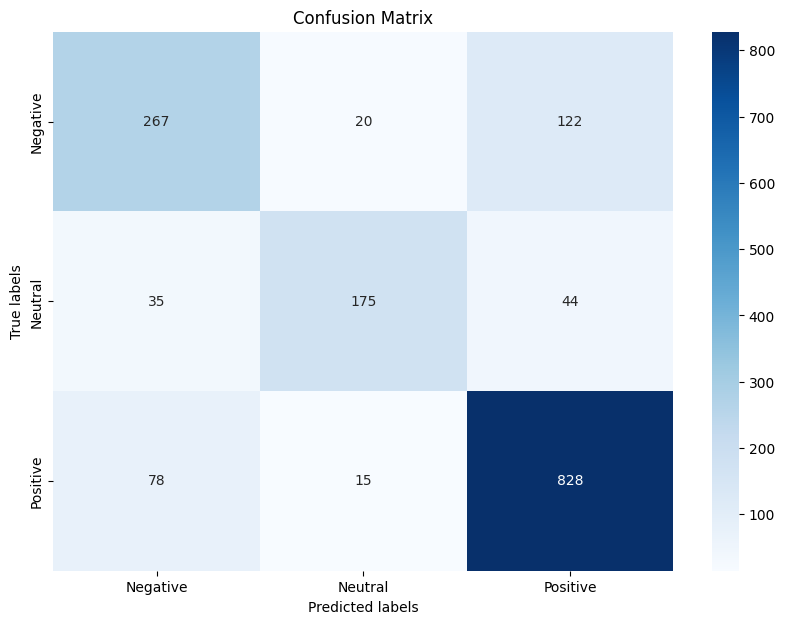

In [ ]:
# Conduct final evaluation on the unseen test dataset
print("\nFinal Evaluation on Test Set:")
cm, report = evaluate_model(electra_model, evaluation_dataloader)

# Define class names for the confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')  # Label for the x-axis
plt.ylabel('True labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

In [ ]:
# For Prof -> since we already saved the model weights, dont have to resave if you are testing this code 

# Save the model's state dictionary
# electra_model_save_path = "/content/drive/My Drive/IR Classification/Models/electra_model_state.bin"
# torch.save(electra_model.state_dict(), electra_model_save_path)